# FNC 8.5 — Exercises 4–6 (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.5 — GMRES**.

- Written exercises **1–3** are answered in `习题解答/na_sol_datahub_8/main.tex`.

We implement **Function 8.5.3** (`gmres`) and a simple restarted variant.


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse


## GMRES (Function 8.5.3) and a restarted wrapper

In [2]:
def _matvec(A, x):
    return A @ x if not sparse.issparse(A) else A.dot(x)


def gmres_basic(A, b, m: int):
    '''Function 8.5.3: do m GMRES iterations for A x = b starting from x0=0.

    Returns (x_m, residual_history) where residual_history has length m+1 and
    stores ||A x_k - b||_2.
    '''
    b = np.asarray(b, dtype=float).reshape(-1)
    n = b.size
    beta0 = float(np.linalg.norm(b))
    if beta0 == 0:
        return np.zeros_like(b), np.zeros(m + 1)

    Q = np.zeros((n, m + 1), dtype=float)
    H = np.zeros((m + 1, m), dtype=float)

    Q[:, 0] = b / beta0

    residual = np.zeros(m + 1, dtype=float)
    residual[0] = beta0

    x = np.zeros(n, dtype=float)

    for j in range(m):
        v = _matvec(A, Q[:, j])
        for i in range(j + 1):
            H[i, j] = float(np.dot(Q[:, i], v))
            v = v - H[i, j] * Q[:, i]
        H[j + 1, j] = float(np.linalg.norm(v))
        if H[j + 1, j] == 0:
            # happy breakdown
            residual[j + 1 :] = residual[j]
            break
        Q[:, j + 1] = v / H[j + 1, j]

        r = np.zeros(j + 2)
        r[0] = beta0
        Hsub = H[: j + 2, : j + 1]
        z, *_ = np.linalg.lstsq(Hsub, r, rcond=None)
        x = Q[:, : j + 1] @ z
        residual[j + 1] = float(np.linalg.norm(_matvec(A, x) - b))

    return x, residual


def gmres_restarted(A, b, m_total: int, restart: int, *, rtol: float = 1e-10):
    '''Simple restarted GMRES wrapper.

    Runs cycles of length `restart` (last one may be shorter) for a total of
    at most `m_total` inner iterations.

    Returns (x, relres_history) with relres_history containing ||r_k||/||b||.
    '''
    b = np.asarray(b, dtype=float).reshape(-1)
    n = b.size
    x = np.zeros(n, dtype=float)
    bnorm = float(np.linalg.norm(b))
    relhist = []

    r = b - _matvec(A, x)
    relhist.append(float(np.linalg.norm(r)) / bnorm)

    it = 0
    while it < m_total and relhist[-1] > rtol:
        m_step = min(restart, m_total - it)
        delta, res = gmres_basic(A, r, m_step)
        # convert cycle residual norms (for A*delta=r) to residual norms for original system
        relhist.extend(list(res[1:] / bnorm))
        x = x + delta
        r = b - _matvec(A, x)
        it += m_step

    return x, np.array(relhist)


## Exercise 4 — GMRES on a tridiagonal system

For each n ∈ {8,16,32,64}:

- A is the n×n tridiagonal matrix with -4 on the diagonal and 1 on the off-diagonals.
- b has entries b_i = i/n.
- Run m=n/2 GMRES iterations and plot ||r_k||/||b|| on one semi-log graph.


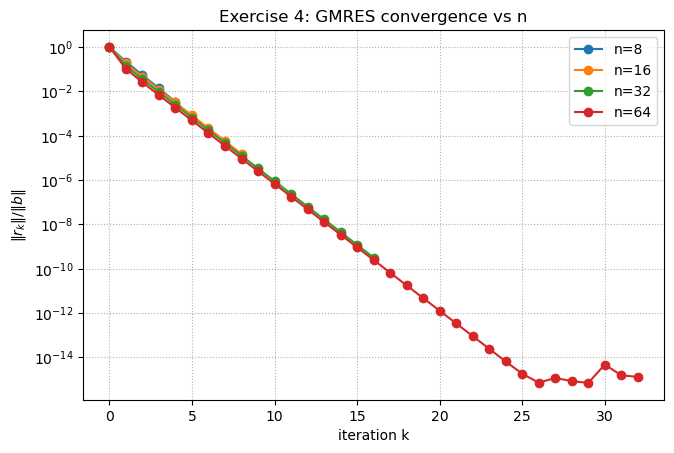

In [3]:
def tri_diag_A(n: int) -> sparse.csc_matrix:
    main = -4.0 * np.ones(n)
    off = 1.0 * np.ones(n - 1)
    return sparse.diags([off, main, off], offsets=[-1, 0, 1], format='csc')


plt.figure(figsize=(7.5, 4.8))

for n in [8, 16, 32, 64]:
    A = tri_diag_A(n)
    b = (np.arange(1, n + 1) / n).astype(float)
    m = n // 2

    _, res = gmres_basic(A, b, m=m)
    rel = res / np.linalg.norm(b)

    plt.semilogy(np.arange(0, m + 1), rel, marker='o', label=f'n={n}')

plt.grid(True, which='both', ls=':')
plt.xlabel('iteration k')
plt.ylabel(r'$\|r_k\|/\|b\|$')
plt.title('Exercise 4: GMRES convergence vs n')
plt.legend()
plt.show()


## Exercise 5 — Effect of eigenvalues and restarting

We define

- B = diag(1,2,…,100)
- I = identity(100)
- Z = 0 (100×100)
- b = ones(200)

and two block-triangular matrices

- A₊ = [[B, I],[Z, B]]
- A₋ = [[B, I],[Z, -B]]

We run GMRES for 100 iterations with tolerance 1e-10:

- without restarts,
- and restarted every 20 iterations.


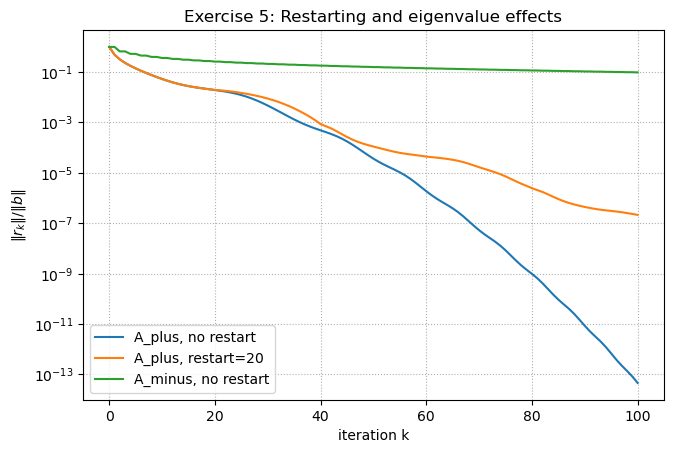

Eigenvalues(A_plus): 1..100 (each twice)
Eigenvalues(A_minus): ±1..±100


In [4]:
B = np.diag(np.arange(1.0, 101.0))
I = np.eye(100)
Z = np.zeros((100, 100))

A_plus = np.block([[B, I], [Z, B]])
A_minus = np.block([[B, I], [Z, -B]])

b = np.ones(200)

# (a) A_plus, no restarts
_, res_plus = gmres_basic(A_plus, b, m=100)
rel_plus = res_plus / np.linalg.norm(b)

# (b) A_plus, restarts every 20
_, rel_plus_r = gmres_restarted(A_plus, b, m_total=100, restart=20, rtol=1e-10)

# (c) A_minus, no restarts
_, res_minus = gmres_basic(A_minus, b, m=100)
rel_minus = res_minus / np.linalg.norm(b)

plt.figure(figsize=(7.5, 4.8))
plt.semilogy(rel_plus, label='A_plus, no restart')
plt.semilogy(rel_plus_r, label='A_plus, restart=20')
plt.semilogy(rel_minus, label='A_minus, no restart')
plt.grid(True, which='both', ls=':')
plt.xlabel('iteration k')
plt.ylabel(r'$\|r_k\|/\|b\|$')
plt.title('Exercise 5: Restarting and eigenvalue effects')
plt.legend()
plt.show()

print('Eigenvalues(A_plus): 1..100 (each twice)')
print('Eigenvalues(A_minus): ±1..±100')


## Exercise 6 — GMRES on the 2D Poisson matrix

We reuse the 2D Poisson matrix from earlier exercises:

\[P = (n+1)^2 (I \otimes T + T \otimes I),\quad T=\operatorname{tridiag}(-1,2,-1).\]

For n ∈ {10,15,20,25}:

- b = ones(n²)
- run 50 GMRES iterations
- plot ||r_k||/||b|| (all four curves on one graph)

For n=25 we also visualize the solution x reshaped as a 25×25 array.


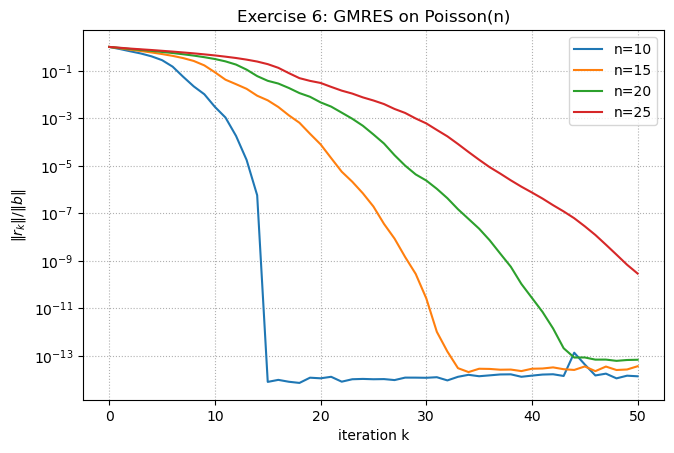

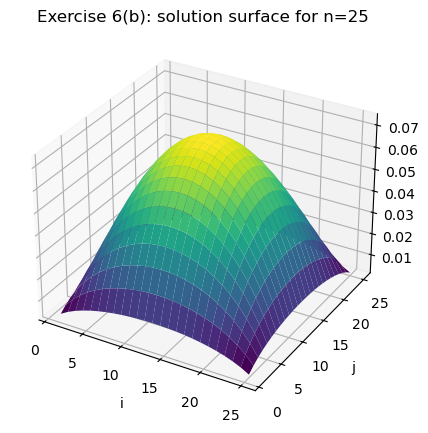

In [5]:
def poisson_2d(n: int) -> sparse.csc_matrix:
    T = sparse.diags(
        diagonals=[-np.ones(n - 1), 2 * np.ones(n), -np.ones(n - 1)],
        offsets=[-1, 0, 1],
        format='csc',
    )
    I = sparse.identity(n, format='csc')
    P = sparse.kron(I, T) + sparse.kron(T, I)
    return ((n + 1) ** 2) * P


plt.figure(figsize=(7.5, 4.8))

solutions = {}

for n in [10, 15, 20, 25]:
    A = poisson_2d(n)
    b = np.ones(n * n)
    x, res = gmres_basic(A, b, m=50)
    rel = res / np.linalg.norm(b)
    plt.semilogy(np.arange(0, 51), rel, label=f'n={n}')
    solutions[n] = x

plt.grid(True, which='both', ls=':')
plt.xlabel('iteration k')
plt.ylabel(r'$\|r_k\|/\|b\|$')
plt.title('Exercise 6: GMRES on Poisson(n)')
plt.legend()
plt.show()

# (b) visualize n=25 solution
n = 25
x = solutions[n].reshape(n, n)

fig = plt.figure(figsize=(7.0, 5.0))
ax = fig.add_subplot(111, projection='3d')
Xg, Yg = np.meshgrid(np.arange(1, n + 1), np.arange(1, n + 1))
ax.plot_surface(Xg, Yg, x, cmap='viridis', linewidth=0, antialiased=True)
ax.set_title('Exercise 6(b): solution surface for n=25')
ax.set_xlabel('i')
ax.set_ylabel('j')
plt.show()
